# SECTION 1: IMPORTS


In [2]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#SECTION 2: THE PREPROCESSING FUNCTION

In [3]:
def preprocess_titanic_data_advanced(train_df, test_df):
    """
    This function preprocesses the Titanic data using the high-performing set of
    advanced feature engineering steps.
    """
    #1. Combine Data for Consistent Processing
    test_ids = test_df['PassengerId']
    survived = train_df['Survived']
    combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], ignore_index=True)

    #2. Handle Initial Missing Values
    combined_df['Age'] = combined_df['Age'].fillna(combined_df['Age'].median())
    combined_df['Fare'] = combined_df['Fare'].fillna(combined_df.groupby('Pclass')['Fare'].transform('median'))
    combined_df['Embarked'] = combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0])

    #3. Engineer Basic Features (Sex, Family/Group Size)
    combined_df['Sex'] = combined_df['Sex'].map({'male': 0, 'female': 1}).astype(int)
    combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1
    combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)
    ticket_counts = combined_df['Ticket'].value_counts()
    combined_df['GroupSize'] = combined_df['Ticket'].map(ticket_counts)

    #4. Extract Titles from Name
    def get_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        if title_search:
            title = title_search.group(1)
            if title in ['Mlle', 'Ms']: return 'Miss'
            if title in ['Mme']: return 'Mrs'
            if title not in ['Mr', 'Miss', 'Mrs', 'Master']: return 'Special'
            return title
        return ""
    combined_df['Title'] = combined_df['Name'].apply(get_title)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Special": 5}
    combined_df['Title'] = combined_df['Title'].map(title_mapping).fillna(0)

    #5. Create LifeStage Group Feature
    #def get_lifestage(row):
       # if row['Age'] < 16: return 'Child'
       # elif row['Age'] >= 60:
         #   if row['Sex'] == 1: return 'OldWoman'
        #    else: return 'OldMan'
       # else:
        #    if row['Sex'] == 1: return 'Woman'
        #    else: return 'Man'
    #combined_df['LifeStage'] = combined_df.apply(get_lifestage, axis=1)
    #lifestage_mapping = {'Child': 0, 'Woman': 1, 'Man': 2, 'OldWoman': 3, 'OldMan': 4}
   # combined_df['LifeStage'] = combined_df['LifeStage'].map(lifestage_mapping)

    #6. Create the Custom 'SurvivalScore
    combined_df['FarePerPerson'] = combined_df['Fare'] / (combined_df['GroupSize'] + 0.0001)
    avg_fare_per_class = combined_df.groupby('Pclass')['FarePerPerson'].transform('mean')
    combined_df['FarePriceAboveAvg'] = combined_df['FarePerPerson'] - avg_fare_per_class
    combined_df['IsChild'] = (combined_df['Age'] < 16).astype(int)
    sex_weight = 5
    class_weight = 2
    child_weight = 5
    combined_df['SurvivalScore'] = (combined_df['Sex'] * sex_weight) + \
                                   ((4 - combined_df['Pclass']) * class_weight) + \
                                   (combined_df['IsChild'] * child_weight) + \
                                   (combined_df['FarePriceAboveAvg'] / 5)

    #7. Keep other useful features
    combined_df['Deck'] = combined_df['Cabin'].str[0].fillna('U')
    deck_mapping = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    combined_df['Deck'] = combined_df['Deck'].map(deck_mapping)
    combined_df['Embarked'] = combined_df['Embarked'].map({'Q': 1, 'S': 2, 'C': 3}).astype(int)

    #8. Create IsMother Feature
    is_woman = combined_df['Sex'] == 1
    is_adult = combined_df['Age'] > 18
    has_children = combined_df['Parch'] > 0
    combined_df['IsMother'] = (is_woman & is_adult & has_children).astype(int)

    #9. Engineer Ticket Prefix Feature
    def get_ticket_prefix(ticket):
        match = re.search(r"([a-zA-Z./]+)", str(ticket))
        if match:
            return match.group(0).upper().replace('.', '').replace('/', '')
        else:
            return 'NONE'
    combined_df['TicketPrefix'] = combined_df['Ticket'].apply(get_ticket_prefix)
    prefix_counts = combined_df['TicketPrefix'].value_counts()
    common_prefixes = prefix_counts[prefix_counts >= 6].index
    for prefix in common_prefixes:
        if prefix != 'NONE':
            combined_df[f'Prefix_{prefix}'] = (combined_df['TicketPrefix'] == prefix).astype(int)
    combined_df['Prefix_Other'] = (~combined_df['TicketPrefix'].isin(common_prefixes)).astype(int)


    #10. Final Cleanup and Splitting
    columns_to_drop = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Fare', 'TicketPrefix', 'FarePerPerson', 'IsChild', 'FarePriceAboveAvg']
    processed_df = combined_df.drop(columns=columns_to_drop)
    train_processed = processed_df.iloc[:len(train_df)].copy()
    test_processed = processed_df.iloc[len(train_df):].copy()
    train_processed['Survived'] = survived
    return train_processed, test_processed, test_ids

# SECTION 3: MAIN EXECUTION BLOCK


--- Loading and Preprocessing Data ---
--- Data Ready for Modeling ---

--- Starting GridSearchCV to find best hyperparameters ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- GridSearchCV Complete ---
Best score found: 85.19%
Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.8}

--- Plotting Confusion Matrix (from cross-validation) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:52] WARNING: /workspace/src/common/

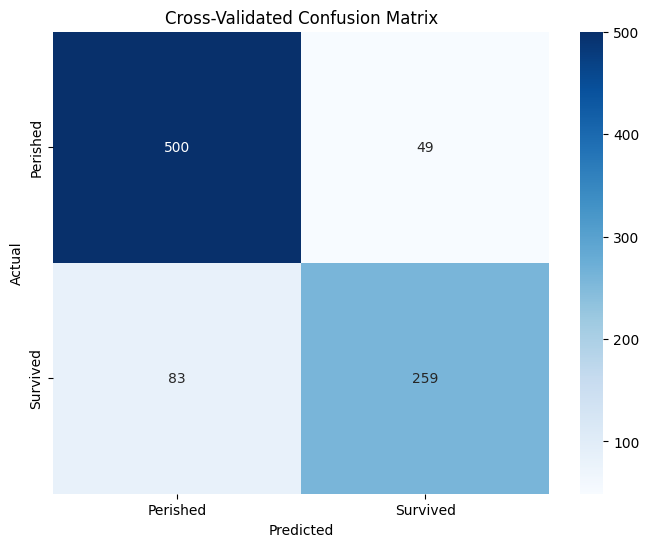


--- Plotting Feature Importance ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<Figure size 1000x1200 with 0 Axes>

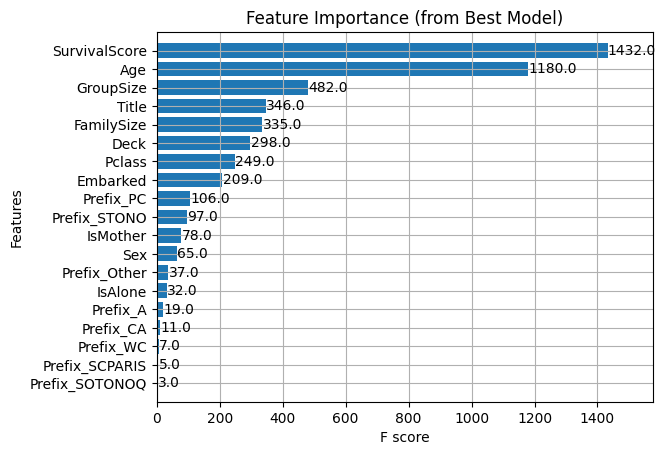


--- Making predictions using the best found model ---
--- Creating final submission file ---
--- Submission file created successfully at: RULREAL.csv ---


In [4]:
if __name__ == '__main__':
    try:
        # --- STEP 1: Load and Preprocess Data ---
        print("--- Loading and Preprocessing Data ---")
        train_data_raw = pd.read_csv('/content/train.csv')
        test_data_raw = pd.read_csv('/content/test.csv')

        processed_train, processed_test, test_passenger_ids = preprocess_titanic_data_advanced(train_data_raw, test_data_raw)

        X = processed_train.drop(['Survived', 'PassengerId'], axis=1)
        y = processed_train['Survived']
        X_test = processed_test.drop('PassengerId', axis=1)
        print("--- Data Ready for Modeling ---")

        # --- STEP 2: Hyperparameter Tuning with GridSearchCV ---
        print("\n--- Starting GridSearchCV to find best hyperparameters ---")

        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='gpu_hist',
            random_state=42
        )

        parameters = {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.05, 0.02, 0.01],
            'n_estimators': [500, 800],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'gamma': [0, 0.1, 0.2]
        }

        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=parameters,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X, y)

        print("\n--- GridSearchCV Complete ---")
        print(f"Best score found: {grid_search.best_score_ * 100:.2f}%")
        print("Best parameters found:")
        print(grid_search.best_params_)

        best_model = grid_search.best_estimator_

        # --- STEP 3: Visualize Performance of the Best Model ---
        print("\n--- Plotting Confusion Matrix (from cross-validation) ---")
        cv_predictions = cross_val_predict(best_model, X, y, cv=5)
        cm = confusion_matrix(y, cv_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Perished', 'Survived'], yticklabels=['Perished', 'Survived'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Cross-Validated Confusion Matrix')
        plt.show()

        print("\n--- Plotting Feature Importance ---")
        plt.figure(figsize=(10, 12))
        xgb.plot_importance(best_model, max_num_features=20, height=0.8)
        plt.title('Feature Importance (from Best Model)')
        plt.show()

        # --- STEP 4: Create Final Submission File ---
        print("\n--- Making predictions using the best found model ---")
        final_predictions = best_model.predict(X_test)

        print("--- Creating final submission file ---")
        submission_df = pd.DataFrame({
            'PassengerId': test_passenger_ids,
            'Survived': final_predictions
        })
        submission_path = 'RULREAL.csv'
        submission_df.to_csv(submission_path, index=False)
        print(f"--- Submission file created successfully at: {submission_path} ---")

    except FileNotFoundError:
        print("ERROR: Please make sure '/content/train.csv' and '/content/test.csv' exist.")
    except Exception as e:
        print(f"An error occurred: {e}")